In [1]:
!pip install transformers accelerate timm --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 req

In [ ]:
import torch
import torch.nn as nn
import timm

class HRNetSeg(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        # load HRNet-W32 pretrained on ImageNet
        self.backbone = timm.create_model(
            "hrnet_w32",
            pretrained=True,
            features_only=True
        )

        # HRNet outputs: [C1, C2, C3, C4] multi-scale features
        # Use the highest-resolution branch (index 0)
        in_ch = self.backbone.feature_info.channels()[0]

        self.seg_head = nn.Sequential(
            nn.Conv2d(in_ch, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, 1)
        )

    def forward(self, x):
        feats = self.backbone(x)[0] 
        return self.seg_head(feats)


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class VITONSegDataset(Dataset):
    def __init__(self, root, split="train", img_size=(512, 384)):
        self.root = root
        self.img_size = img_size
        
        # Paths
        self.image_dir = os.path.join(root, split, "image")
        self.mask_dir = os.path.join(root, split, "image-parse-v3")
        
        self.images = sorted(os.listdir(self.image_dir))
        
        self.img_transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(), # [0, 1]
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        
        # Mask Transform (Nearest Neighbor to keep integers)
        self.mask_transform = transforms.Resize(self.img_size, interpolation=transforms.InterpolationMode.NEAREST)

    def __len__(self):
        return len(self.images)
    
    def process_mask(self, mask_pil):
        # Map VITON-HD labels to 3 Classes:
        # 0: Background
        # 1: Upper Cloth (5,6,7)
        # 2: Body/Skin (Face, Arms, Neck, etc)
        
        mask_np = np.array(mask_pil)
        new_mask = np.zeros_like(mask_np)
        
        # Define Labels
        # 5=Upper, 6=Dress, 7=Coat
        cloth_labels = [5, 6, 7] 
        # 10=Neck, 11=Face, 13=Hair, 14=L_Arm, 15=R_Arm
        body_labels = [10, 11, 13, 14, 15] 
        
        for l in cloth_labels:
            new_mask[mask_np == l] = 1
        for l in body_labels:
            new_mask[mask_np == l] = 2
            
        return torch.from_numpy(new_mask).long()

    def __getitem__(self, idx):
        img_name = self.images[idx]
        
        
        img = Image.open(os.path.join(self.image_dir, img_name)).convert("RGB")
        mask_name = img_name.replace(".jpg", ".png")
        mask = Image.open(os.path.join(self.mask_dir, mask_name))
        
        
        img_t = self.img_transform(img)
        mask_t = self.mask_transform(mask)
        
        
        mask_t = self.process_mask(mask_t)
        
        return img_t, mask_t

In [ ]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

model = HRNetSeg(num_classes=3)  


if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_data = VITONSegDataset("/kaggle/input/high-resolution-viton-zalando-dataset", "train")
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)


model.safetensors:   0%|          | 0.00/165M [00:00<?, ?B/s]

Unexpected keys (downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.num_batches_tracked, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.num_batches_tracked, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.num_batches_tracked, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Using 2 GPUs


In [5]:
from tqdm import tqdm
import torch.nn.functional as F

for epoch in range(5):
    model.train()
    epoch_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)

    for imgs, targets in pbar:
        imgs = imgs.to(device)
        targets = targets.to(device)

        outputs = model(imgs)

        
        outputs = F.interpolate(
            outputs,
            size=targets.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        pbar.set_postfix({
            "batch_loss": f"{loss.item():.4f}",
            # "avg_loss": f"{epoch_loss / (pbar.n):.4f}"
        })

    print(f"Epoch {epoch+1} | Avg Loss: {epoch_loss / len(train_loader):.4f}")


Epoch 1: 100%|██████████| 5824/5824 [39:20<00:00,  2.47it/s, batch_loss=0.2920]


Epoch 1 | Avg Loss: 0.3903


Epoch 2: 100%|██████████| 5824/5824 [37:43<00:00,  2.57it/s, batch_loss=0.3930]


Epoch 2 | Avg Loss: 0.3355


Epoch 3: 100%|██████████| 5824/5824 [35:47<00:00,  2.71it/s, batch_loss=0.4695]


Epoch 3 | Avg Loss: 0.3156


Epoch 4: 100%|██████████| 5824/5824 [38:23<00:00,  2.53it/s, batch_loss=0.4534]


Epoch 4 | Avg Loss: 0.3008


Epoch 5: 100%|██████████| 5824/5824 [37:34<00:00,  2.58it/s, batch_loss=0.1793]

Epoch 5 | Avg Loss: 0.2903


In [6]:
save_path = "hrnet_finetuned.pth"

if isinstance(model, nn.DataParallel):
    torch.save(model.module.state_dict(), save_path)
else:
    torch.save(model.state_dict(), save_path)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def compute_miou(pred_mask, target_mask, num_classes=3):
    pred = pred_mask.flatten()
    target = target_mask.flatten()
    
    
    cm = confusion_matrix(target, pred, labels=range(num_classes))

    intersection = np.diag(cm)
    union = cm.sum(axis=1) + cm.sum(axis=0) - intersection
    
    # Avoid division by zero
    iou = intersection / (union + 1e-6)
    
    return np.mean(iou), iou

def denormalize(tensor):
    
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    img = tensor.cpu().numpy().transpose(1, 2, 0) # (C,H,W) -> (H,W,C)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

def visualize_batch(model, loader, device, num_images=2):
    model.eval()
    
    
    imgs, targets = next(iter(loader))
    imgs, targets = imgs.to(device), targets.to(device)
    
    with torch.no_grad():
        outputs = model(imgs)
        
    
        outputs = torch.nn.functional.interpolate(
            outputs, 
            size=targets.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
    
        preds = torch.argmax(outputs, dim=1)
        
    
    preds_np = preds.cpu().numpy()
    targets_np = targets.cpu().numpy()
    
    
    miou, class_iou = compute_miou(preds_np, targets_np, num_classes=3)
    print(f"--- Batch Evaluation ---")
    print(f"Mean IoU: {miou:.4f}")
    print(f"Class IoU: {class_iou}")
    print(f"(0: Backg, 1: Cloth, 2: Skin)")
    print("-" * 30)

    
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    
    
    if num_images == 1: axes = [axes]
        
    for i in range(num_images):
        # 1. Input Image
        ax_img = axes[i][0] if num_images > 1 else axes[0]
        ax_img.imshow(denormalize(imgs[i]))
        ax_img.set_title("Input Image")
        ax_img.axis('off')
        
        # 2. Ground Truth
        ax_gt = axes[i][1] if num_images > 1 else axes[1]
        ax_gt.imshow(targets_np[i], cmap='viridis', vmin=0, vmax=2)
        ax_gt.set_title("Ground Truth")
        ax_gt.axis('off')
        
        # 3. Prediction
        ax_pred = axes[i][2] if num_images > 1 else axes[2]
        ax_pred.imshow(preds_np[i], cmap='viridis', vmin=0, vmax=2)
        ax_pred.set_title(f"Prediction (IoU: {class_iou.mean():.2f})")
        ax_pred.axis('off')
        
    plt.tight_layout()
    plt.show()

--- Batch Evaluation ---
Mean IoU: 0.6742
Class IoU: [0.81249455 0.33098429 0.87921761]
(0: Backg, 1: Cloth, 2: Skin)
------------------------------


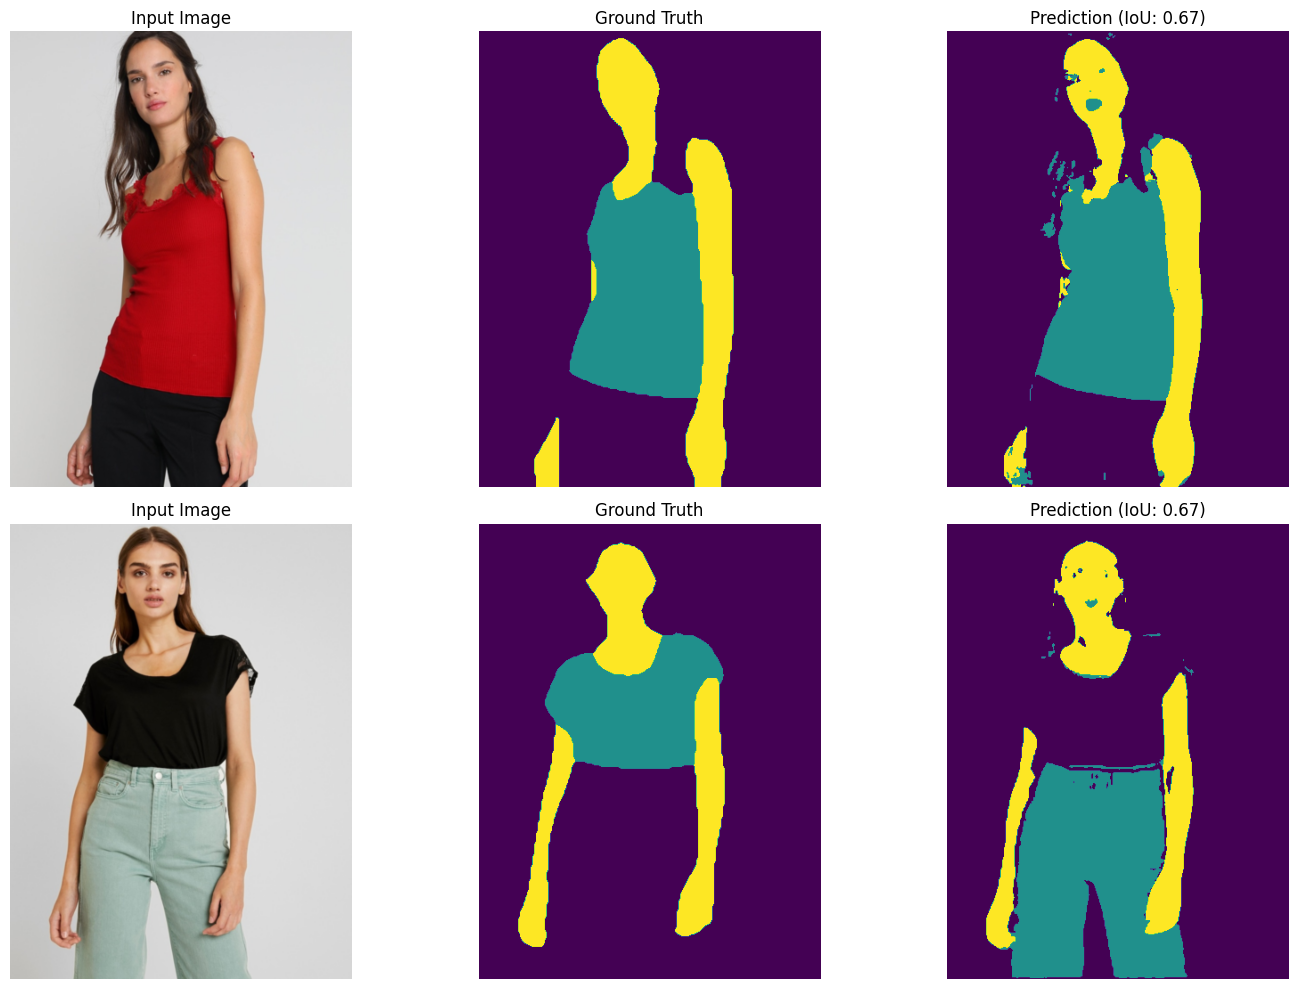

In [8]:
visualize_batch(model, train_loader, device, num_images=2)